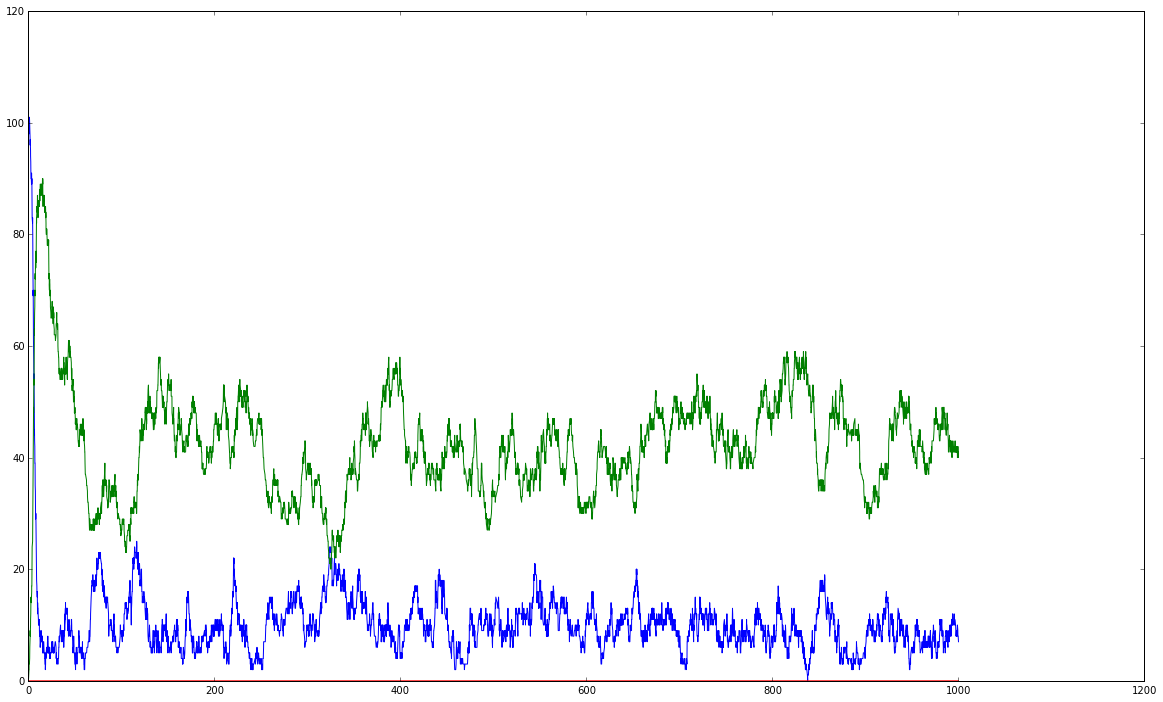

In [1]:
#coding=utf-8

from sympy import symbols
import numpy as np
import matplotlib.pyplot as pl

import gillespie
from gillespie import integrate
from gillespie import cython_propensity_function
reload(gillespie)

%matplotlib inline

X, Y, Z = symbols('X Y Z', integer=True)
B, l, mu, nu = symbols('β λ μ ν', real=True)

x = [X, Y, Z]

T = [
    {X: -1, Y: 1},
    {X: -1, Y: 1},
    {X:  1},
    {Y: -1}
]

prop = [
  B*X*Y,
  nu*X,
  l,
  mu*Y
]

ics = {
  X: 100,
  Y: 0
}

parm = {
  B: 0.005,
  l: 2,
  mu: 0.05,
  nu: 0.01
}

y = list(integrate(x, T, prop, parm, ics, 1000))
t, y1, y2, y3 = np.transpose(y)

pl.figure(figsize=(20,12))
ax = pl.plot(t, y1, t, y2, t, y3)

In [ ]:

print x

[np.asarray(ics.get(xi,0)) for xi in x]


In [ ]:
np.array([100])+np.array([1,2])

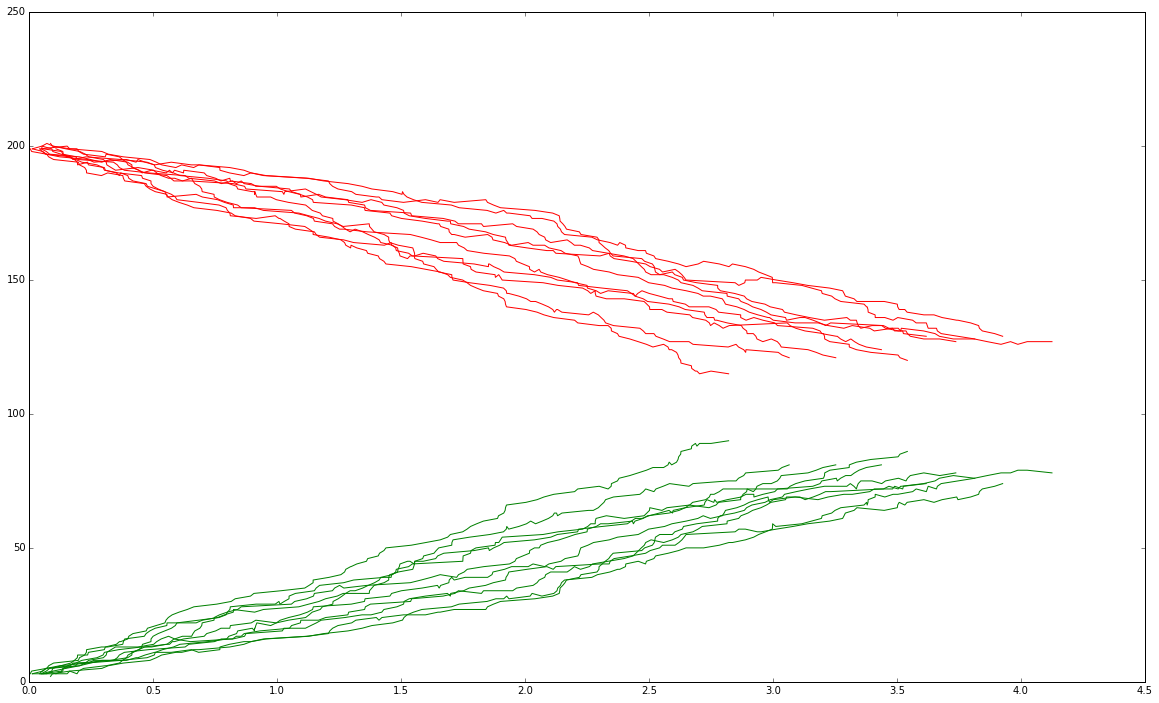

None


/Users/lturner/git/.pydev/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


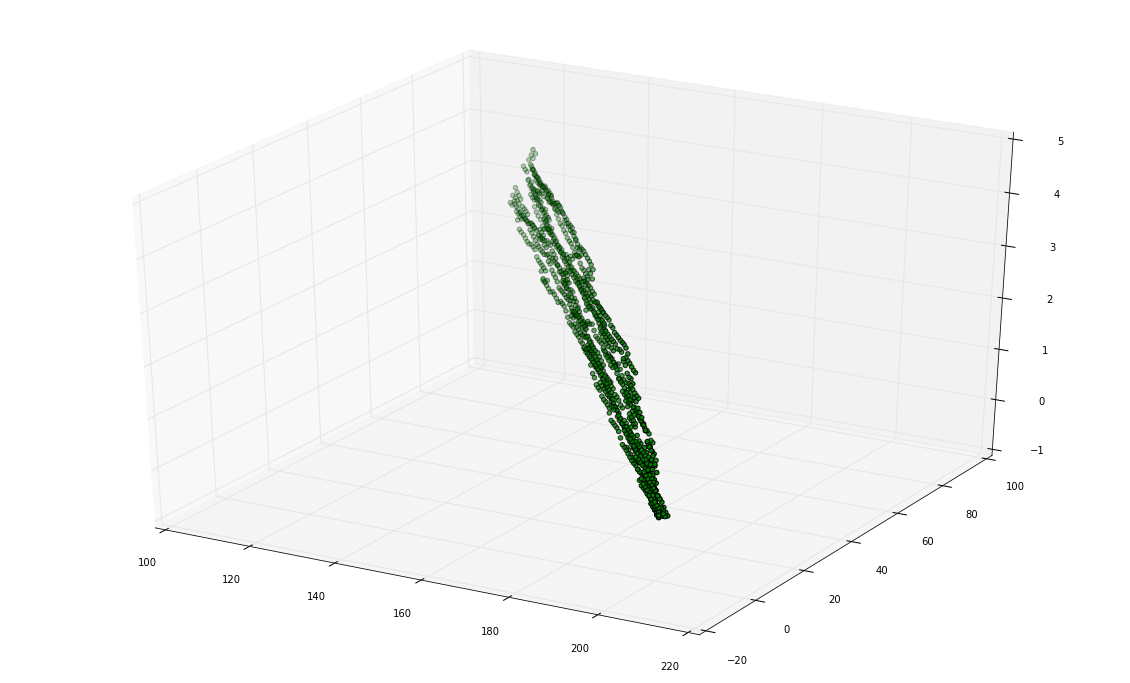

In [1]:
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D as ax3D

%matplotlib inline

from theano.tensor.shared_randomstreams import RandomStreams


    #t = [
    #    {X: -1, Y: 1},
    #    {X: -1, Y: 1},
    #    {X:  1},
    #    {Y: -1}
    #]


"""
p: reaction propensities
"""
def function(var, parm, p, S, seed=233):
    
    S = np.asarray(S)

    reps = var[0].shape[0]
    
    rng = RandomStreams(seed=seed) #todo: makes sure it runs on GPU
    r_u = rng.uniform((1,reps))
    
    p_n = sum(p)
    prob = [p_i/p_n for p_i in p]
    
    v = tt.stack(prob).reshape((len(p),reps)).T #This happens because of variables as dvectors (rxns, reps)
    
    #TODO: check prb_f for nans
    prb_f = theano.function(var+parm, v)
    
    tau_f = theano.function(var+parm, (1/p_n)*tt.log(1/r_u))
    
    ran_f = theano.function(var+parm, rng.multinomial(n=1, pvals=v))
    
    def compute(ics, parm, interval):
        x = ics
        reps = ics[0].shape[0]
        time = np.zeros(shape=(1,reps))
        out = np.zeros(shape=(reps, interval, len(var)+1)) #(rep, time, vars+time)

        for idx in range(interval):
    
            args = [x[0],x[1]]+parm

            time += tau_f(*args)

            ran_i = ran_f(*args)
            incr = np.dot(ran_i, S).T

            x = np.asarray(x)+incr
            out[:,idx,:] = np.concatenate((time, x)).T
        
        return out
    
    return compute


X, Y = map(tt.dvector, "XY")
B, l, mu, nu = map(tt.dscalar, ["β", "λ", "μ", "ν"])
P = [B*X*Y, nu*X, l, mu*Y]
r = 10
intervals = 100
S = [
    [-1, 1],
    [-1, 1],
    [ 1, 0],
    [ 0,-1]
]

fn = function([X, Y], [B, l, mu, nu], P, S)
out = fn([np.asarray([200]*r),np.asarray([2]*r)], [0.001, 2, 0.05, 0.1], intervals)

fig = pl.figure(figsize=(20,12))
for q in range(r):
    pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")
print pl.show()
    
fig = pl.figure(figsize=(20,12))

ax = fig.add_subplot(111, projection='3d')
for q in range(r):
    ax.scatter(out[q,:,1].reshape((intervals)), out[q,:,2].reshape((intervals)), zs=out[q,:,0:1].reshape((intervals)), c='green')


1 loops, best of 3: 11.4 s per loop


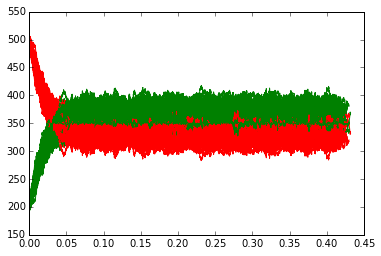

None


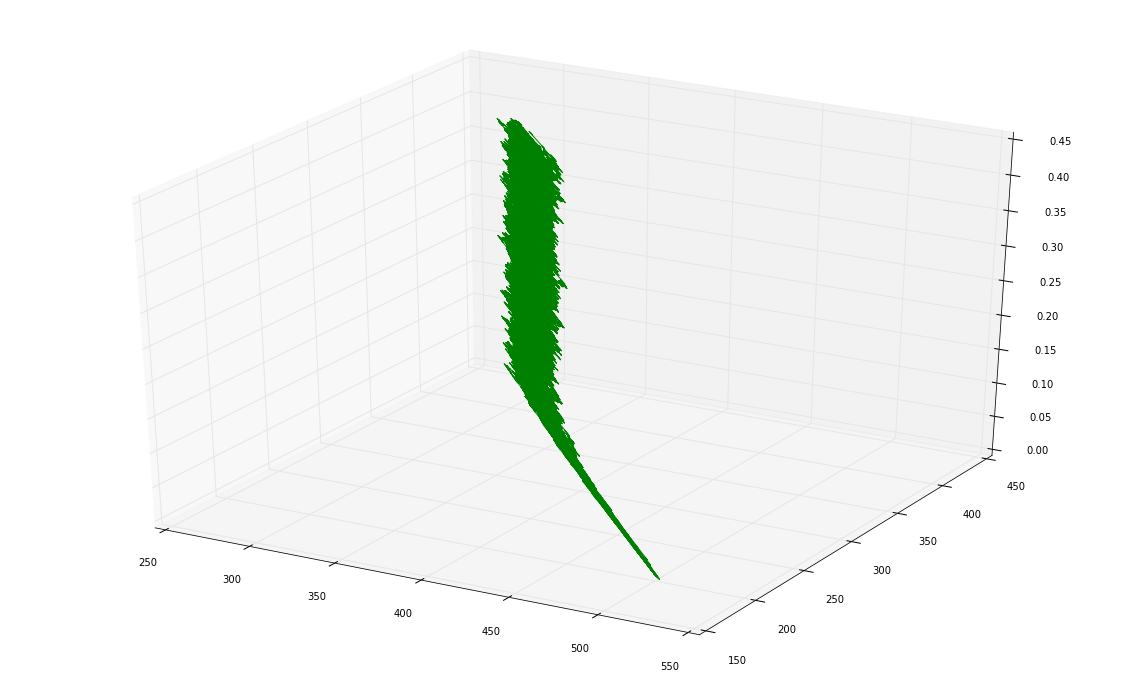

In [20]:
X, Y = map(tt.dvector, "XY")
B, mu = map(tt.dscalar, ['β', 'μ'])
P = [B*X*Y, mu*tt.square(Y)]
r = 100
intervals = 10000
S = [
    [-1, 1],
    [ 1,-1]
]

fn = gillespie_integrator([X, Y], [B, mu], P, S, reps=r)
%timeit fn([np.asarray([500]*r),np.asarray([200]*r)], [0.1, 0.09], intervals)
out = fn([np.asarray([500]*r),np.asarray([200]*r)], [0.1, 0.09], intervals)

for q in range(r):
    pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")
print pl.show()
    
fig = pl.figure(figsize=(20,12))

ax = fig.add_subplot(111, projection='3d')
for q in range(r):
    ax.plot(out[q,:,1].reshape((intervals)), out[q,:,2].reshape((intervals)), zs=out[q,:,0:1].reshape((intervals)), c='green')


In [1]:
import numpy as np
from scipy import stats
from mayavi import mlab

mu, sigma = 0, 0.1 
x = 10*np.random.normal(mu, sigma, 5000)
y = 10*np.random.normal(mu, sigma, 5000)
z = 10*np.random.normal(mu, sigma, 5000)

xyz = np.vstack([x,y,z])
kde = stats.gaussian_kde(xyz)
density = kde(xyz)

# Plot scatter with mayavi
figure = mlab.figure('DensityPlot')
pts = mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.07)
mlab.axes()
mlab.show()

ImportError: No module named mayavi

In [ ]:
import theano.tensor as T
x = T.dvector('x')
y = T.dmatrix('y')

fn = theano.function([x,y], 2*T.dot(x,y))

x_, y_ = np.array([1,2,3]), np.array([
        [3,2,1,5,1,7],
        [1,2,4,6,1,8],
        [4,5,6,7,1,1]
    ])

fn(x_,y_)

In [ ]:
np.array([1,3,4]).T

In [ ]:
rng = RandomStreams(seed=234)

Z = tt.dmatrix('Z')
fn_ = theano.function([Z], rng.multinomial(n=1, pvals=Z))

In [ ]:
S = np.zeros(shape=(2,2), dtype=np.float32)

z = np.asarray(map(lambda i: fn_(np.array([[0.5,0.5],[0.1,0.9]])), range(100)), dtype=np.float32)

print np.sum(z, axis=0)/np.sum(z, axis=(0,2), keepdims=True)


In [ ]:
sum([1,2])

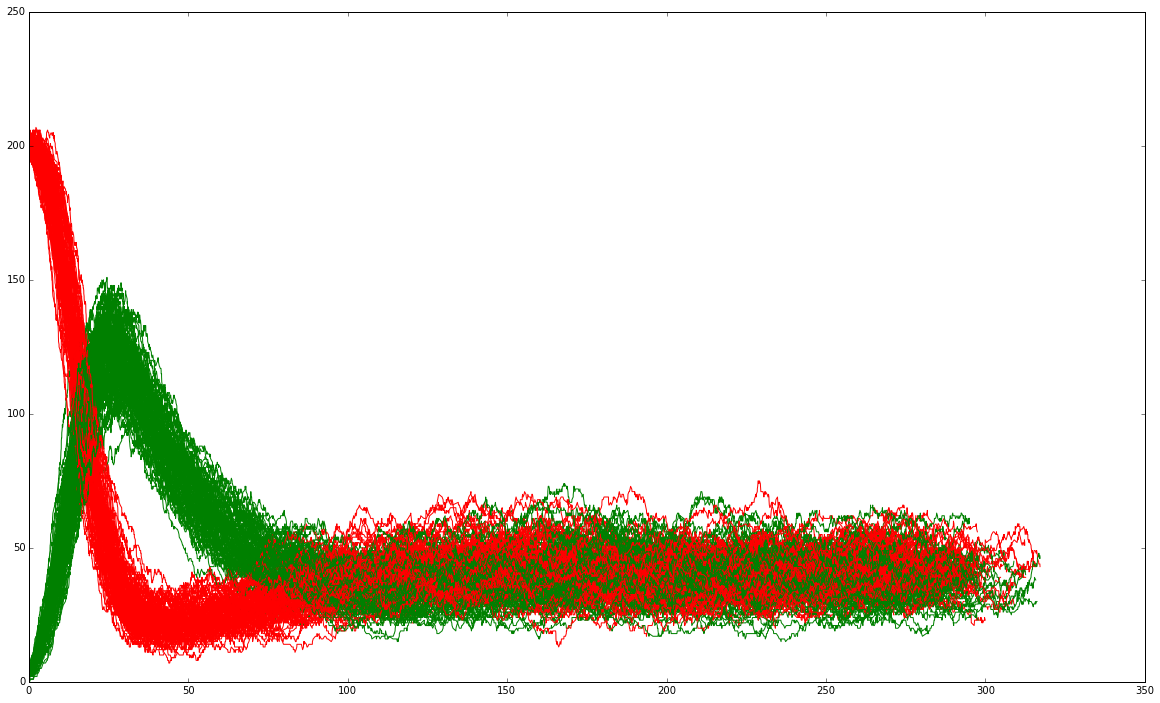

None


In [29]:
import numpy as np
import theano
import theano.tensor as tt
import matplotlib.pyplot as pl
import gillespie.vec as gv
reload(gv)

%matplotlib inline

X, Y = map(tt.dvector, "XY")
B, l, mu, nu = map(tt.dscalar, ["β", "λ", "μ", "ν"])
P = [B*X*Y, nu*X, l, mu*Y]
S = [
    [-1, 1],
    [-1, 1],
    [ 1, 0],
    [ 0,-1]
]
fn = gv.function([X, Y], [B, l, mu, nu], P, S)

r = 100
intervals = 2000
out = fn([np.asarray([200]*r),np.asarray([2]*r)], [0.001, 2, 0.05, 0.01], intervals)

fig = pl.figure(figsize=(20,12))
for q in range(r):
    pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")
print pl.show()

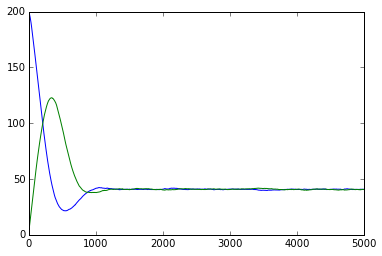

In [24]:
out.shape
pl.plot(out.mean(axis=0)[:,1:])

done


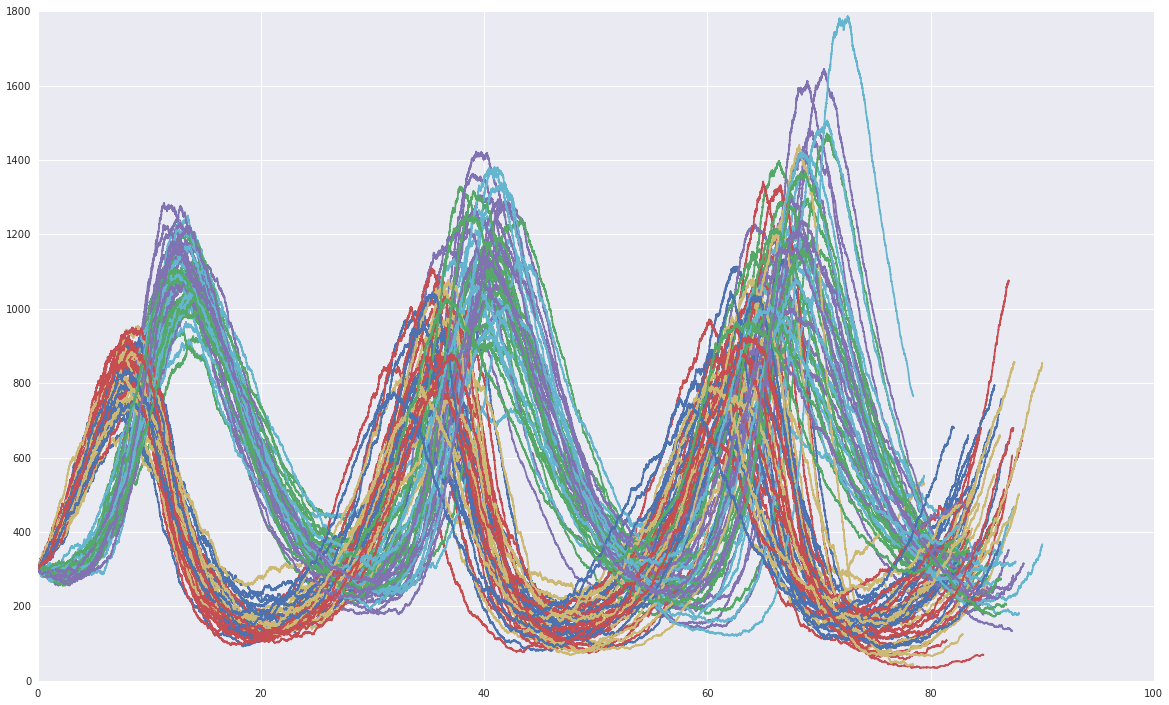

In [81]:
%matplotlib inline

import numpy as np
import seaborn as sb
import theano.tensor as tt
import matplotlib.pyplot as pl
import gillespie.vec as gv
reload(gv)
"""
dX
-- = alphaX - betaXY
dt

dY
-- = betaXY - muY
dt
"""

X, Y = map(tt.dvector, "XY")
a, B, mu = map(tt.dscalar, ["a","β","μ"])
P = [a*X, B*X*Y, mu*Y]
S = [
    [ 1, 0],
    [-1, 1],
    [ 0,-1]
]

r = 50
intervals = 30000
fn = gv.function([X, Y], [a, B, mu], P, S)

out = fn([np.asarray([300]*r), np.asarray([300]*r)], [0.3, 0.0005, 0.2], intervals)
print "done"

fig = pl.figure(figsize=(20,12))
for q in range(r):
    pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")


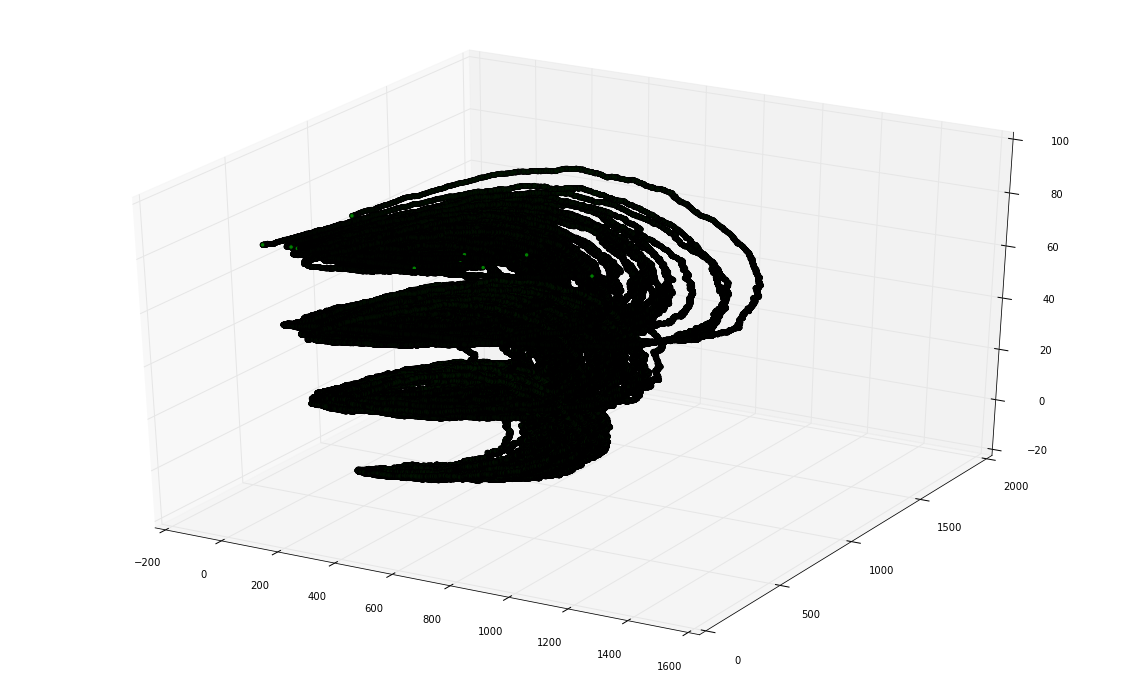

In [75]:
from mpl_toolkits.mplot3d import Axes3D as ax3D

fig = pl.figure(figsize=(20,12))

ax = fig.add_subplot(111, projection='3d')
for q in range(r):
    ax.scatter(out[q,:,1].reshape((intervals)), out[q,:,2].reshape((intervals)), zs=out[q,:,0:1].reshape((intervals)), c='green')
